In [28]:
from typing import Optional
import matplotlib.pyplot as plt
import math
import numpy as np

import pyramid


def display_4d_array(array):
    R, C, _, _ = array.shape
    params = dict()
    print(array.shape)

    for i, row in enumerate(array):
        for j, img in enumerate(row):
            params[f"{i}_{j}"] = img
    display_arrays(cols=C, rows=R, **params)


def display_3d_array(array):
    dummy_batch_dimension = jnp.expand_dims(array, 0)
    return display_4d_array(dummy_batch_dimension)


def display_first_batch_arrays(rows: int = 1, cols: Optional[int] = None, **batched_image_kwargs):
    d = {key: jnp.squeeze(img, axis=0) for key, img in batched_image_kwargs.items()}
    return display_arrays(**d)


def display_arrays(rows: int = 1, cols: Optional[int] = None, **images_kwargs):
    """
    Displays multiple image arrays using Matplotlib in a grid layout.

    Args:
        rows: The number of rows in the subplot grid.
        cols: The number of columns in the subplot grid.
        **images_kwargs: Keyword arguments where each key is the title
                         and each value is a 2D numpy/jax array (image).
    """
    num_images = len(images_kwargs)
    if num_images == 0:
        print("No images provided to display.")
        return

    if cols is None:
        cols = math.ceil(num_images / rows)
    if rows * cols < num_images:
        print(
            f"Warning: Not enough subplots ({rows}x{cols}={rows * cols}) for {num_images} images. "
            f"Some images will not be displayed.")
        # Optionally, you could adjust rows/cols or raise an error

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust figsize as needed

    # If rows=1 and cols=1, axes is not an array but a single AxesSubplot object.
    # If rows=1 or cols=1, axes is a 1D array.
    # Otherwise, axes is a 2D array.
    # We flatten it for easier iteration.
    if isinstance(axes, plt.Axes):  # Single subplot
        axes_flat = [axes]
    else:
        axes_flat = axes.flatten()

    for i, (title, img_array) in enumerate(images_kwargs.items()):
        if i >= len(axes_flat):
            break  # Stop if we run out of subplots

        ax = axes_flat[i]
        # Convert JAX array to NumPy array if it's not already, for matplotlib
        # Matplotlib usually handles JAX arrays fine, but explicit conversion is safer.
        img_to_plot = np.asarray(img_array)

        im = ax.imshow(img_to_plot, cmap='cividis')  # You can change the colormap
        ax.set_title(title)
        ax.axis('off')  # Hide axes ticks and labels

    # Hide any unused subplots
    for j in range(num_images, len(axes_flat)):
        axes_flat[j].axis('off')

    plt.tight_layout()
    plt.show()



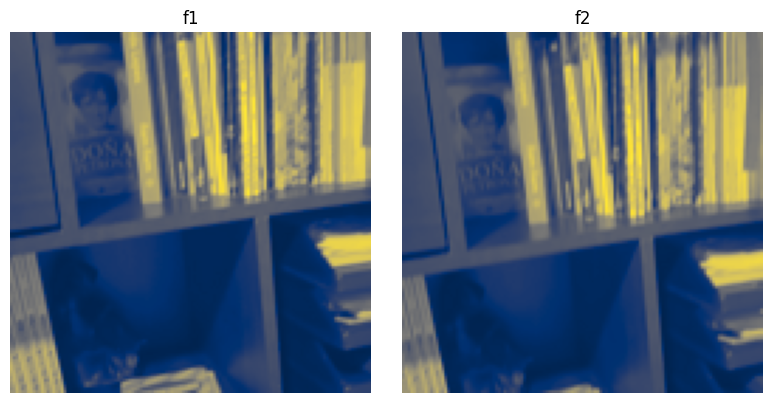

In [27]:
from pathlib import Path
from PIL import Image
import jax.numpy as jnp
from IPython.display import display
import jax


def load_image_to_array(img_path: Path) -> jax.Array:
    img = Image.open(img_path)
    as_array = jnp.asarray(img)
    assert as_array.ndim == 2
    return as_array / 255.0


f1 = load_image_to_array(Path('./datasets/frames/bookshelf/frame_000200.png'))
f2 = load_image_to_array(Path('./datasets/frames/bookshelf/frame_000205.png'))

display_arrays(f1=f1, f2=f2)



(1, 4, 64, 64)


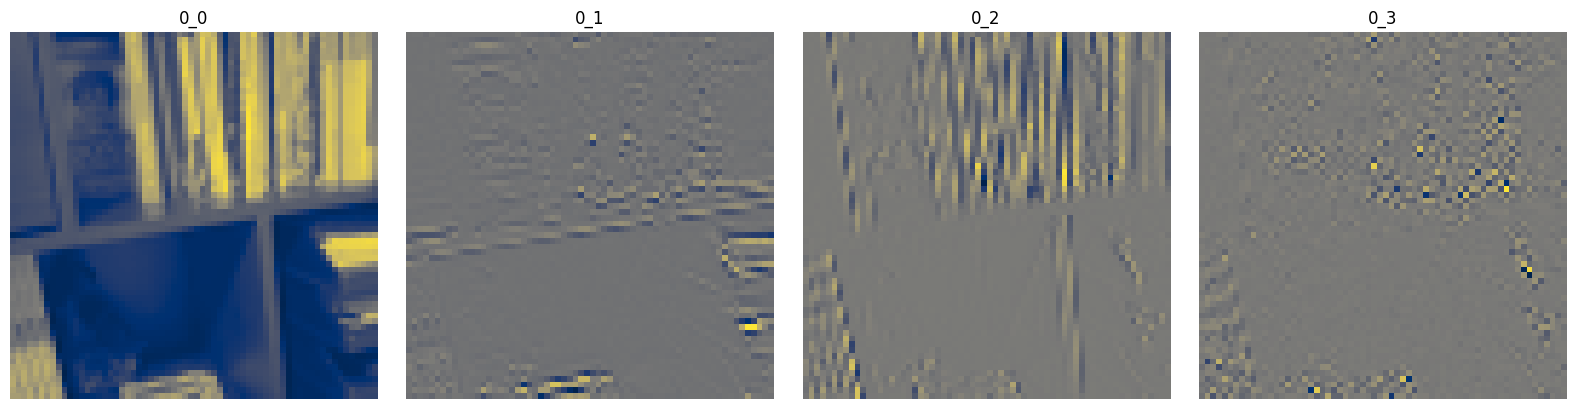

(1, 4, 64, 64)


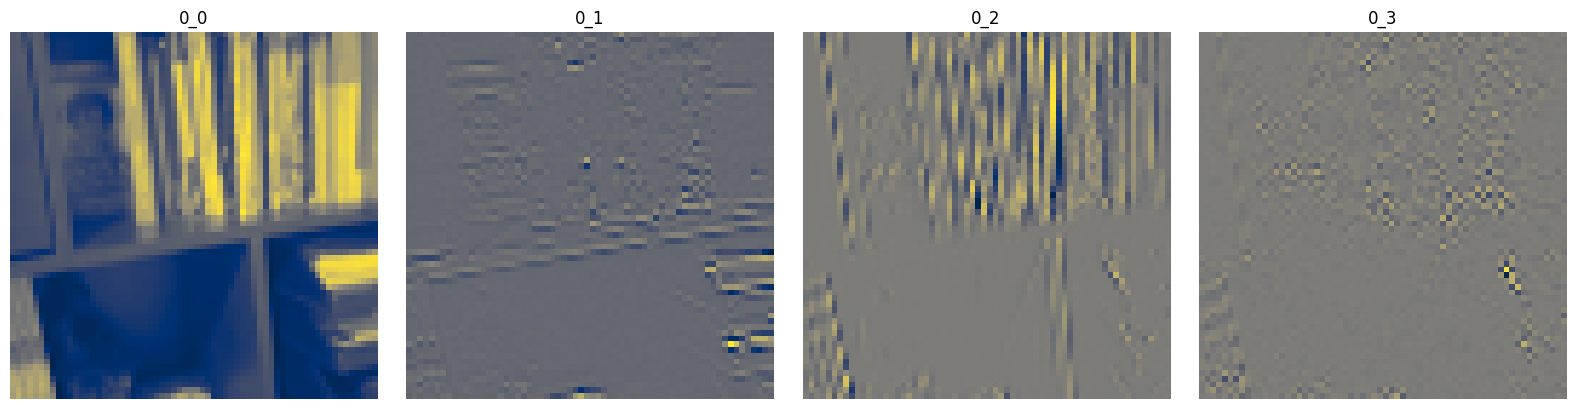

(1, 4, 32, 32)


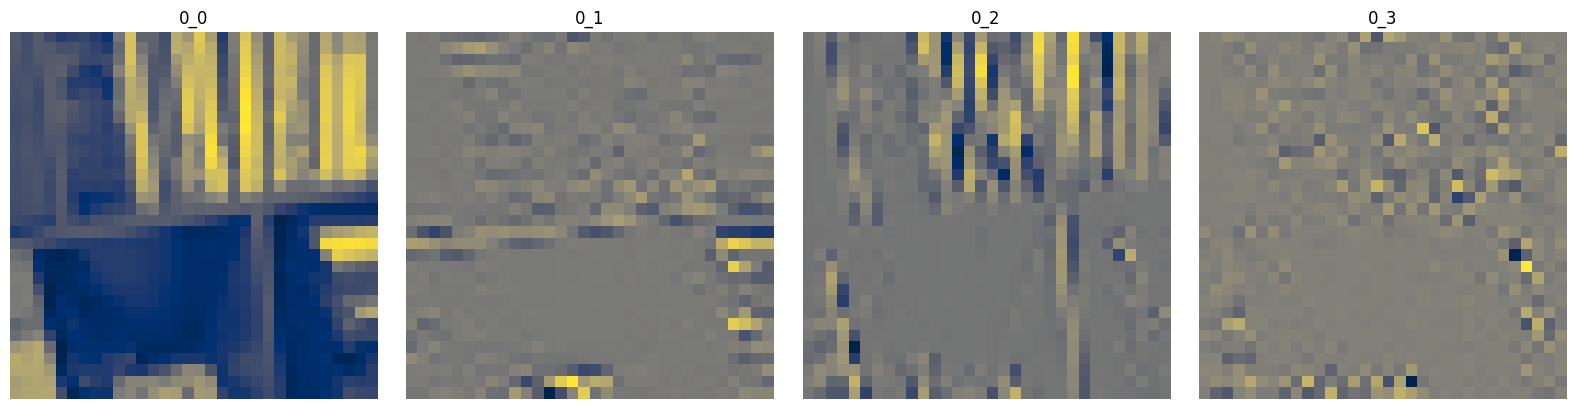

(1, 4, 32, 32)


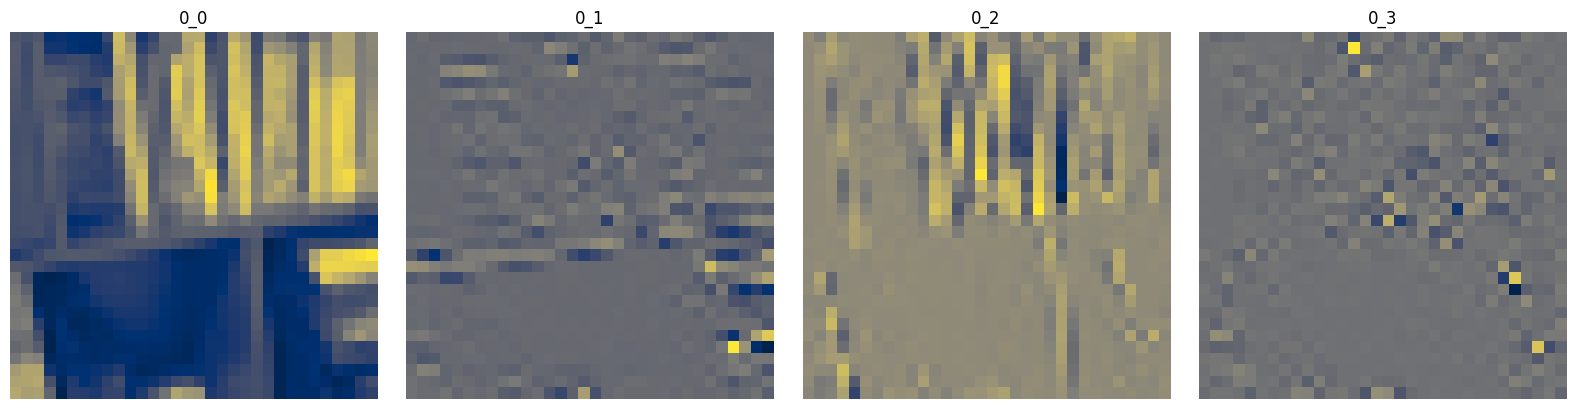

(1, 4, 16, 16)


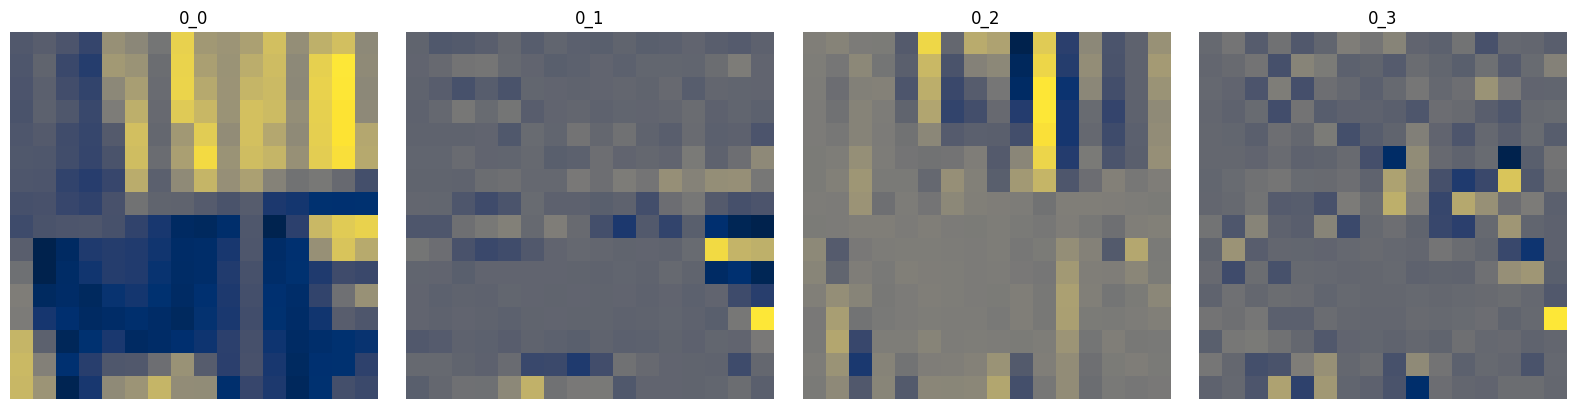

(1, 4, 16, 16)


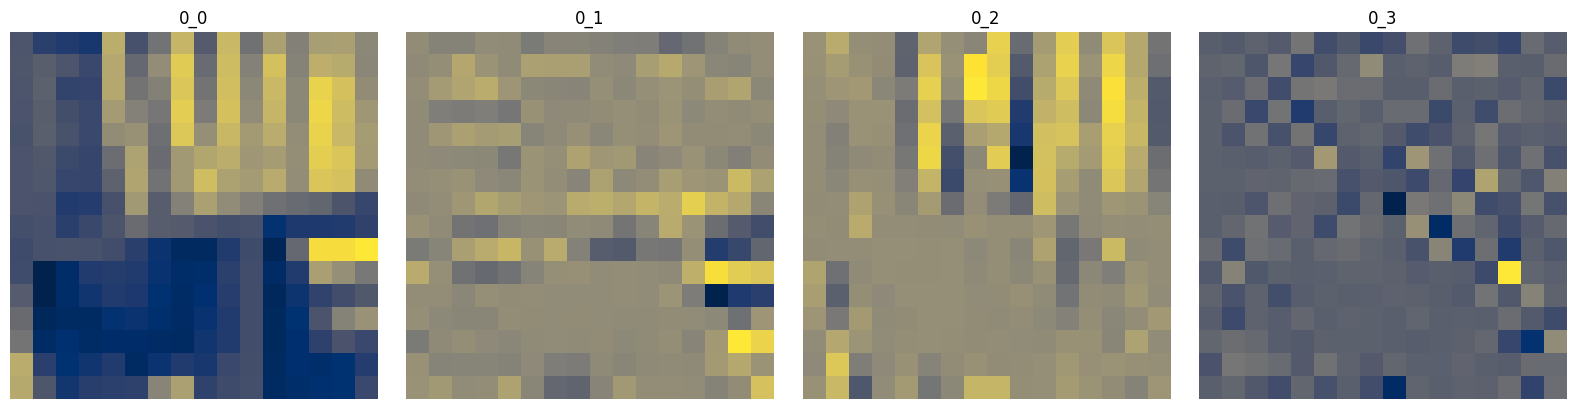

(1, 4, 8, 8)


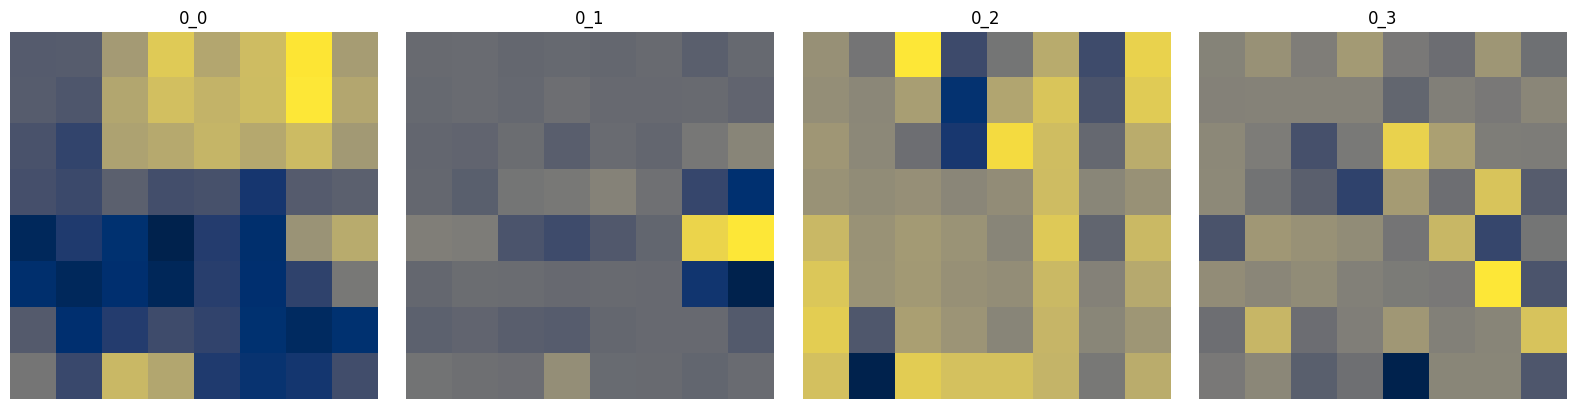

(1, 4, 8, 8)


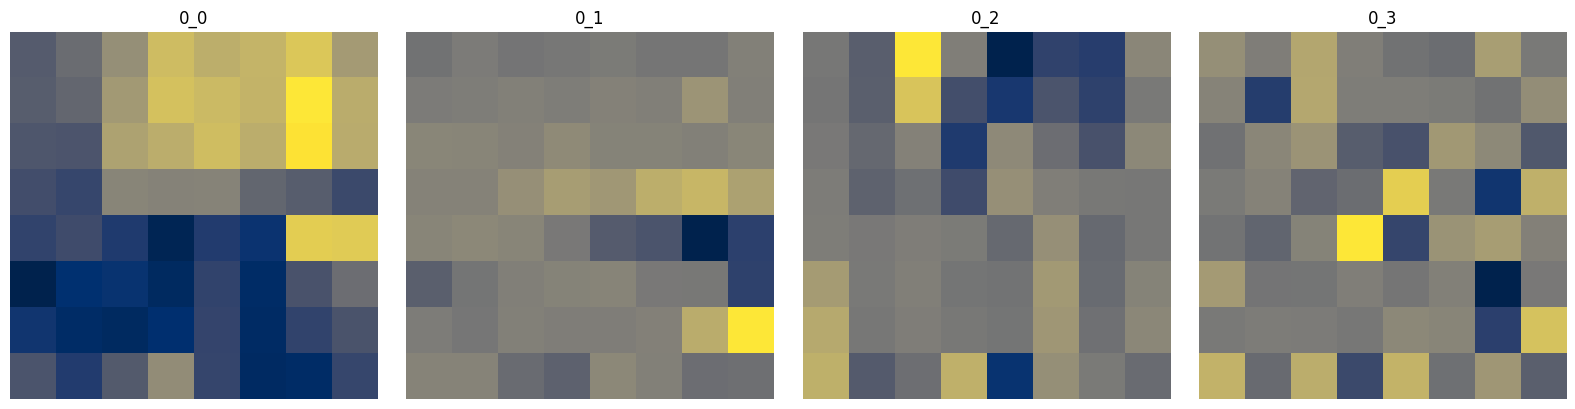

(1, 4, 4, 4)


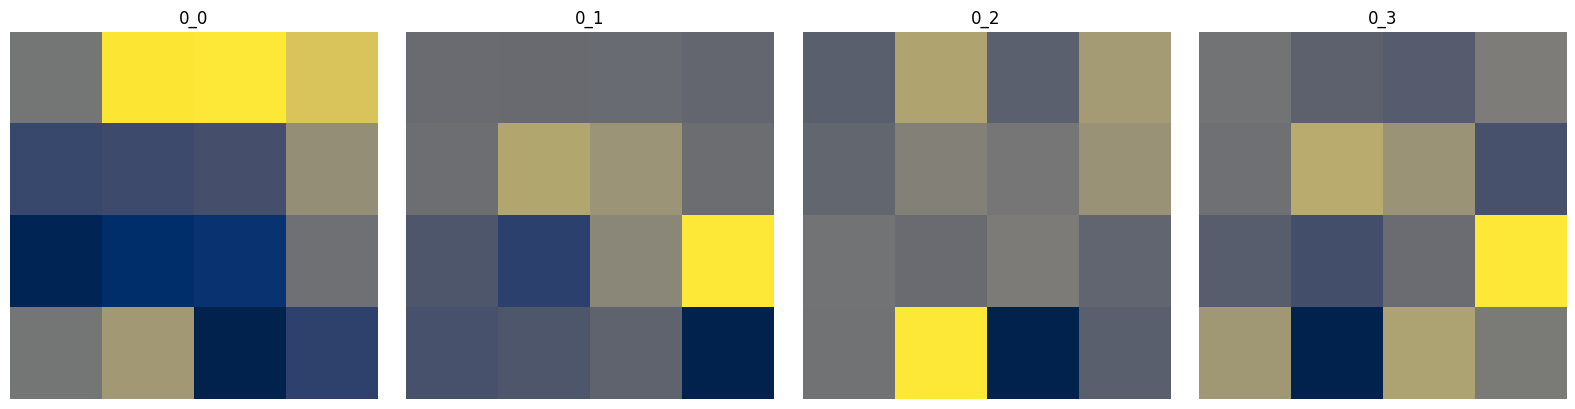

(1, 4, 4, 4)


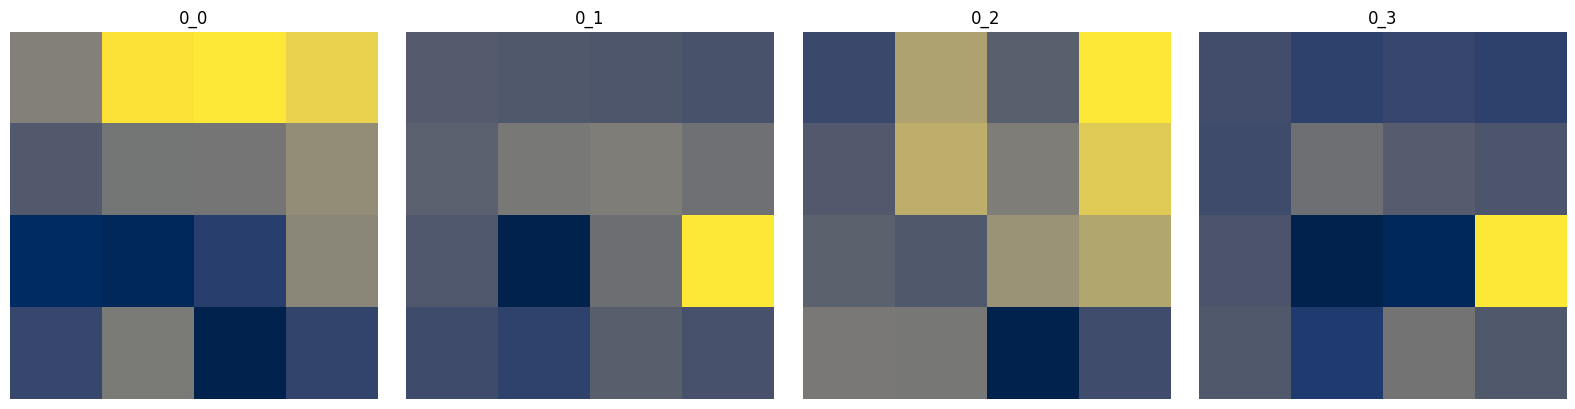

(1, 4, 2, 2)


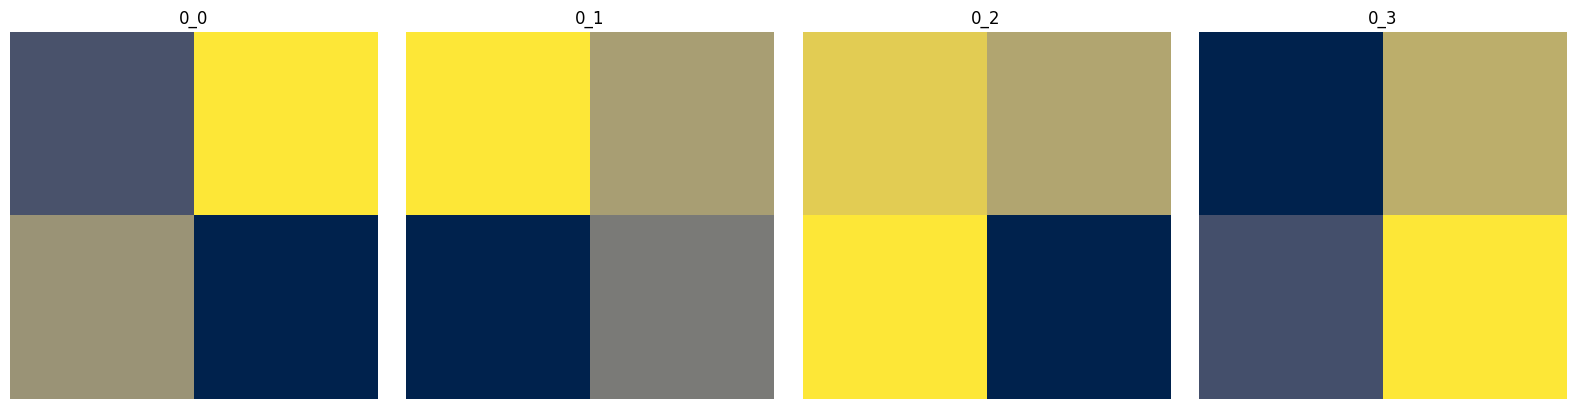

(1, 4, 2, 2)


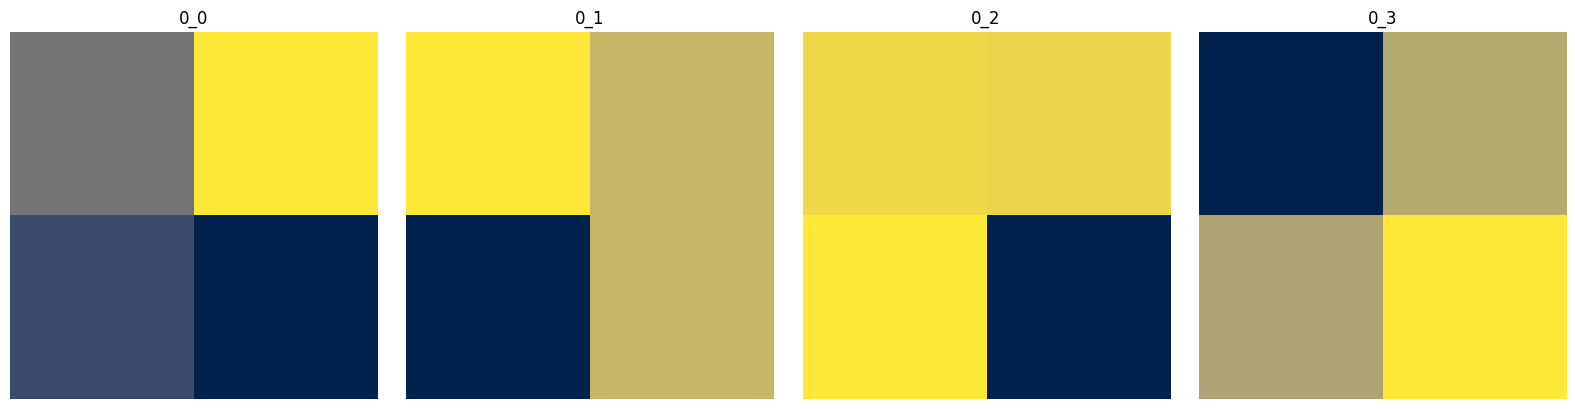

In [29]:
# wavelet transform, keeping the LL channel along the way.
import jax.numpy as jnp
import pywt


def make_kernels(lo, hi):
    ll = jnp.outer(lo, lo)
    lh = jnp.outer(hi, lo)
    hl = jnp.outer(lo, hi)
    hh = jnp.outer(hi, hi)
    filters = jnp.stack([ll, lh, hl, hh], 0)
    filters = jnp.expand_dims(filters, 1)
    return filters


def wavedec2(
        img: jnp.ndarray,
        wavelet: str,
        levels: int,
) -> list[tuple[jax.Array, jax.Array, jax.Array, jax.Array]]:
    py_wavelet = pywt.Wavelet(wavelet)
    kernels = make_kernels(
        jnp.array(py_wavelet.dec_lo), jnp.array(py_wavelet.dec_hi)
    )
    current = img
    pyramid = []
    for _ in range(levels):
        padded = jnp.pad(current, ((0,0),(0,0), (1,1), (1,1)), mode='edge')
        # padded = current
        decomposed = jax.lax.conv_general_dilated(
            padded,
            kernels,
            window_strides=(2, 2),
            padding='valid',
            dimension_numbers=('NCHW', 'OIHW', 'NCHW')
        )
        current = decomposed[:, :1]
        pyramid.append(decomposed.squeeze(0))

    return pyramid

pyramid1 = wavedec2(f1[jnp.newaxis, jnp.newaxis, ...], 'db2', levels=6)
pyramid2 = wavedec2(f2[jnp.newaxis, jnp.newaxis, ...], 'db2', levels=6)
for c1, c2 in zip(pyramid1, pyramid2):
    pass
    # print(jnp.mean(c1, axis=(2,3)))
    # print(c1)
    m = jnp.max(jnp.array([jnp.max(c1), jnp.max(c2)]))
    display_3d_array(c1 / m)
    display_3d_array(c2 / m)


/tmp/ipykernel_835870/1153624059.py:103: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmax' will be ignored
  ax.scatter(originals, guess_improvement_ratio, vmax=2.0)


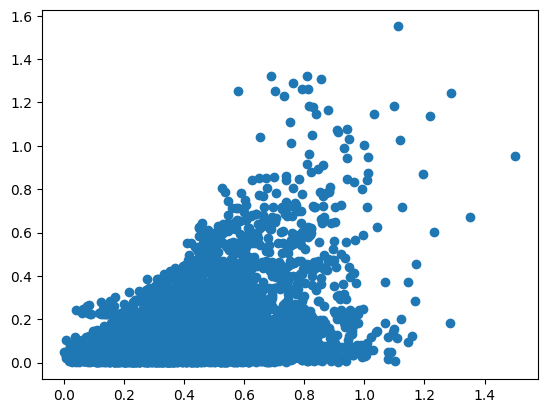

0.10119726


In [5]:
import jax
import jax.numpy as jnp


def extract_flowed_sub_patch(patch: jax.Array, flow: jax.Array) -> jax.Array:
    H, W = patch.shape
    grid_y, grid_x = jnp.meshgrid(jnp.arange(1, H - 1), jnp.arange(1, W - 1), indexing='ij')
    source_coords_y = grid_y + flow[0]
    source_coords_x = grid_x + flow[1]
    source_coords = jnp.stack([source_coords_y.ravel(), source_coords_x.ravel()])  # Shape (2,
    # ((H-2)*(H-2))
    resampled_values = jax.scipy.ndimage.map_coordinates(
        patch,
        source_coords,
        order=1,
        mode='constant'
    )
    return resampled_values.reshape(H - 2, W - 2)


def get_warped_patch_without_context_window(patch: jax.Array, flow: jax.Array) -> jax.Array:
    H, W = patch.shape
    grid_y, grid_x = jnp.meshgrid(jnp.arange(H), jnp.arange(W), indexing='ij')
    source_coords_y = grid_y + flow[0]
    source_coords_x = grid_x + flow[1]
    source_coords = jnp.stack([source_coords_y.ravel(), source_coords_x.ravel()])
    # Shape (2, H*W)
    resampled_values = jax.scipy.ndimage.map_coordinates(
        patch,
        source_coords,
        order=1,
        mode='constant'
    )
    return resampled_values.reshape(H, W)


def patch_pair_similarity(patch1: jax.Array, patch2: jax.Array) -> jax.Array:
    """
    Calculates the NCC between two single 2D patches (H, W).
    This function is designed to be maximized for perfect match.
    """
    mean1 = jnp.mean(patch1)
    mean2 = jnp.mean(patch2)
    std1 = jnp.std(patch1) + 1e-6
    std2 = jnp.std(patch2) + 1e-6
    numerator = jnp.sum((patch1 - mean1) * (patch2 - mean2))
    denominator = std1 * std2 * jnp.prod(jnp.array(patch1.shape))
    return jnp.clip(numerator / denominator, -1.0, 1.0)


batched_patch_pair_similarity = jax.vmap(patch_pair_similarity)


@jax.jit
def flowed_patch_similarity(target_patch: jax.Array, source_patch: jax.Array, flow: jax.Array) -> (
        jax
        .Array):
    # target_patch is HxW
    # source_patch is (H+2, W+2)
    # flow is (2)
    warped_source = get_warped_patch_without_context_window(source_patch, flow)
    return patch_pair_similarity(target_patch, warped_source)


batched_flowed_patch_similarity = jax.vmap(flowed_patch_similarity)

flow_diff_similarity_grad = jax.jit(jax.grad(flowed_patch_similarity, argnums=2))

carry_key = jax.random.key(1125)
originals = []
guess_improvement_ratio = []
for experiment in range(100):
    carry_key, use_key = jax.random.split(carry_key)
    large_patch = jax.random.normal(use_key, (4, 4))

    carry_key, use_key = jax.random.split(carry_key)
    target_flow = jax.random.normal(use_key, (2,)) * 0.3

    # original_patch = extract_flowed_sub_patch(large_patch, target_flow)
    original_patch = get_warped_patch_without_context_window(large_patch, target_flow)

    carry_key, use_key = jax.random.split(carry_key)
    original_patch += jax.random.normal(use_key, original_patch.shape) * 0.1

    for aim in range(100):
        carry_key, use_key = jax.random.split(carry_key)
        guess_flow = target_flow + jax.random.normal(use_key, target_flow.shape) * 0.3
        originally_off_by = jax.numpy.linalg.norm(guess_flow - target_flow)
        for i in range(10):
            similarity = flowed_patch_similarity(original_patch, large_patch, guess_flow)
            grad = flow_diff_similarity_grad(original_patch, large_patch, guess_flow)
            guess_flow = guess_flow + grad * 0.2
        perfect_flow_similarity = flowed_patch_similarity(original_patch, large_patch, target_flow)

        final_error = jax.numpy.linalg.norm(guess_flow - target_flow)
        original_error = originally_off_by
        originals.append(original_error)
        # guess_improvement_ratio.append(final_error / (original_error + 1e-9))
        guess_improvement_ratio.append(final_error)

fig = plt.figure()
ax = plt.gca()
ax.scatter(originals, guess_improvement_ratio, vmax=2.0)
# ax.set_yscale('log')
plt.show()
print(jnp.mean(jnp.array(guess_improvement_ratio)))

# print(flow_diff_similarity(original_patches[0], patches[0], actual_flow[0]))

# flow_diff_similarity(original_patches[0], patches[0], jnp.array([0.1, -0.2]))

#
# print(original_patches[0])
# print(warped_patches[0])
# print(patch_pair_similarity(original_patches[0], warped_patches[0]))


In [6]:
batched_flowed_patch_similarity = jax.vmap(flowed_patch_similarity)
batched_warp_patch = jax.vmap(extract_flowed_sub_patch)
carry_key = jax.random.key(374)

jnp.set_printoptions(precision=3)
carry_key, use_key = jax.random.split(carry_key)
B = 2
W = H = 4
batch_of_patches = jax.random.normal(use_key, (B, W + 2, H + 2)) * 0.2
batch_of_flows = jax.random.normal(use_key, (B, 2)) * 0.2
warped_patches = batched_warp_patch(batch_of_patches, batch_of_flows)
print(batch_of_patches, batch_of_flows, warped_patches)
carry_key, use_key = jax.random.split(carry_key)
batch_of_flow_guesses = batch_of_flows + jax.random.normal(use_key, batch_of_flows.shape) * 0.3
batched_flowed_patch_similarity(warped_patches, batch_of_patches, batch_of_flow_guesses)


[[[ 0.006 -0.205  0.198  0.157  0.126  0.232]
  [-0.159  0.035  0.103  0.241  0.09  -0.052]
  [-0.117  0.328 -0.024 -0.225  0.087 -0.031]
  [-0.038  0.155  0.032  0.151  0.081 -0.238]
  [ 0.02   0.056 -0.022  0.162 -0.28   0.04 ]
  [-0.263 -0.015  0.411 -0.055  0.237 -0.236]]

 [[ 0.355  0.196 -0.065  0.116  0.055  0.112]
  [-0.036  0.312  0.298  0.073  0.18   0.163]
  [ 0.098 -0.231  0.085 -0.204  0.175  0.029]
  [ 0.289 -0.04   0.072  0.458 -0.334  0.074]
  [ 0.132 -0.222 -0.262 -0.345 -0.155  0.353]
  [-0.103  0.1   -0.199 -0.055 -0.059  0.272]]] [[ 0.006 -0.205]
 [ 0.198  0.157]] [[[-0.003  0.089  0.21   0.12 ]
  [ 0.236  0.048 -0.182  0.024]
  [ 0.115  0.057  0.126  0.093]
  [ 0.048 -0.004  0.124 -0.188]]

 [[ 0.213  0.218  0.043  0.172]
  [-0.15   0.058 -0.05   0.068]
  [-0.063  0.052  0.205 -0.231]
  [-0.173 -0.255 -0.264 -0.062]]]


TypeError: mul got incompatible shapes for broadcasting: (4, 4), (6, 6).

In [7]:


def expand_2plus1(a: jax.Array) -> jax.Array:
    """
    Given an array of shape B, H, W,
    return an array of shape B, 2*H+2, 2*W+2
    where each entry in the original array is expanded to a 2x2 block, plus the first and last
    rows and columns are repeated once more.
    """
    doubled = a.repeat(repeats=2, axis=1).repeat(repeats=2, axis=2)
    return jnp.pad(doubled, ((0, 0), (1, 1), (1, 1)), mode='edge')


def smooth_kernel3(a: jax.Array) -> jax.Array:
    """
    Smoothen entries on an array(img) by interpolating each entry with their neighbors with a
    specific kernel.
    The borders are copied over so that the kernel has enough context for smoothing.
    """
    extra_borders = jnp.pad(a, ((0, 0), (1, 1), (1, 1)), mode='edge')
    extra_borders_extra_dim = jnp.expand_dims(extra_borders, axis=1)
    kernel = jnp.array([[0.7, 1, 0.7], [1, 7, 1], [0.7, 1, 0.7]]).reshape(1, 1, 3, 3)
    # ^ totally made up smoothing kernel. this should be learned.
    norm_kernel = kernel / jnp.sum(kernel)
    smoothed_extra_dim = jax.lax.conv(extra_borders_extra_dim, norm_kernel, (1, 1), 'valid')
    smoothed = smoothed_extra_dim.squeeze(axis=(0, 1))
    return smoothed


def upsample(decimal_flows: jax.Array, whole_flows: jax.Array, smooth: bool = False) -> tuple[jax
.Array,
jax.Array]:
    # given flows determined by
    # a decimal fraction flow(2d) in an array of  of B,H,W,2, float
    # an integer flow(2d) is an array of B,H,W,2, int (likely int8)
    # return a tuple of 2 arrays:
    # an array of B, 2*H+2, 2*W+2, 2 (float) of residual flows (-1 < flow_d < 1)
    # an array of B, 2*H+2, 2*W+2, 2 (int) of integer flows.
    # a flow value in one direction of i.f will convert to round(2(i.f)) on the integer
    # array, and round_reminder(2*i.f) on the floating point array.
    total_flow_upscaled = 2 * (decimal_flows + whole_flows)
    expanded = expand_2plus1(total_flow_upscaled)
    if smooth:
        expanded = smooth_kernel3(expanded)
    expanded_upscaled_whole_flow = jnp.round(expanded).astype(jnp.int32)
    expanded_upscaled_decimal_flow = expanded - expanded_upscaled_whole_flow
    return expanded_upscaled_decimal_flow, expanded_upscaled_whole_flow


jnp.set_printoptions(precision=4)

# sample_whole = jnp.full((1, 1, 1), 1)
# sample_decimal = jnp.full((1, 1, 1), 0.6)
# upsampled = upsample(sample_decimal, sample_whole)

sample_whole2 = jnp.arange(0, 4).reshape(1, 2, 2)
sample_decimal2 = jnp.arange(0, 4 * 0.2, 0.2).reshape(1, 2, 2)
print(upsample(sample_decimal2, sample_whole2, smooth=False))
print(upsample(sample_decimal2, sample_whole2, smooth=True))


(Array([[[ 0. ,  0. ,  0. ,  0.4,  0.4,  0.4],
        [ 0. ,  0. ,  0. ,  0.4,  0.4,  0.4],
        [ 0. ,  0. ,  0. ,  0.4,  0.4,  0.4],
        [-0.2, -0.2, -0.2,  0.2,  0.2,  0.2],
        [-0.2, -0.2, -0.2,  0.2,  0.2,  0.2],
        [-0.2, -0.2, -0.2,  0.2,  0.2,  0.2]]], dtype=float32), Array([[[0, 0, 0, 2, 2, 2],
        [0, 0, 0, 2, 2, 2],
        [0, 0, 0, 2, 2, 2],
        [5, 5, 5, 7, 7, 7],
        [5, 5, 5, 7, 7, 7],
        [5, 5, 5, 7, 7, 7]]], dtype=int32))
(Array([[ 0.    ,  0.    ,  0.4174, -0.0174,  0.4   ,  0.4   ],
       [ 0.    ,  0.    ,  0.4174, -0.0174,  0.4   ,  0.4   ],
       [-0.1652, -0.1652,  0.2522, -0.1826,  0.2348,  0.2348],
       [-0.0348, -0.0348,  0.3826, -0.0522,  0.3652,  0.3652],
       [-0.2   , -0.2   ,  0.2174, -0.2174,  0.2   ,  0.2   ],
       [-0.2   , -0.2   ,  0.2174, -0.2174,  0.2   ,  0.2   ]],      dtype=float32), Array([[0, 0, 0, 2, 2, 2],
       [0, 0, 0, 2, 2, 2],
       [1, 1, 1, 3, 3, 3],
       [4, 4, 4, 6, 6, 6],
       [5, 5

In [8]:
def extract_non_overlapping_patches(images, patch_size):
    C, H, W = images.shape
    P = patch_size
    if H % P != 0 or W % P != 0:
        raise ValueError("Image dimensions must be multiples of patch_size.")

    horizontal_patches = H // P
    vertical_patches = W // P
    reshaped_images = images.reshape(C, horizontal_patches, P, vertical_patches, P)
    permuted_images = reshaped_images.transpose(1, 3, 0, 2, 4)
    final_patches = permuted_images.reshape(horizontal_patches * vertical_patches, C, P, P)
    return final_patches


a = jnp.arange(32).reshape(2, 4, 4)
print(a)
p = extract_non_overlapping_patches(a, patch_size=2)
print(p.shape)


[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]]
(4, 2, 2, 2)


In [9]:
def extract_shifted_patches_multi_channel(frame, int_flows, patch_size):
    # flows is (2, H//P, H//P)
    C, H, W = frame.shape
    P = patch_size

    num_patches_H = H // P
    num_patches_W = W // P
    grid_y_coords, grid_x_coords = jnp.meshgrid(jnp.arange(num_patches_H),
                                                jnp.arange(num_patches_W),
                                                indexing='ij')
    grid_y_offsets = grid_y_coords * P
    grid_x_offsets = grid_x_coords * P

    int_flows_y = int_flows[0]  # dy
    int_flows_x = int_flows[1]  # dx

    start_y_all_patches = grid_y_offsets + int_flows_y
    start_x_all_patches = grid_x_offsets + int_flows_x
    start_coords_flattened = jnp.stack([start_y_all_patches.ravel(), start_x_all_patches.ravel()],
                                       axis=-1)

    def _extract_single_shifted_patch(start_yx):
        start_y, start_x = start_yx[0], start_yx[1]

        return jax.lax.dynamic_slice(frame, (0, start_y, start_x), (C, P, P))

    shifted_patches_batch = jax.vmap(_extract_single_shifted_patch, in_axes=0, out_axes=0)(
        start_coords_flattened)

    return shifted_patches_batch


a = jnp.arange(36).reshape(1, 6, 6)
flow = jnp.array([
    [
        [1, 1, 0],
        [2, 1, 3],
        [-1, 0, 1]
    ], [
        [0, 1, 1],
        [1, 0, -1],
        [0, -1, 1]
    ]])
print(a)
patches = extract_shifted_patches_multi_channel(a, flow, patch_size=2)
print(patches.shape)

[[[ 0  1  2  3  4  5]
  [ 6  7  8  9 10 11]
  [12 13 14 15 16 17]
  [18 19 20 21 22 23]
  [24 25 26 27 28 29]
  [30 31 32 33 34 35]]]
(9, 1, 2, 2)


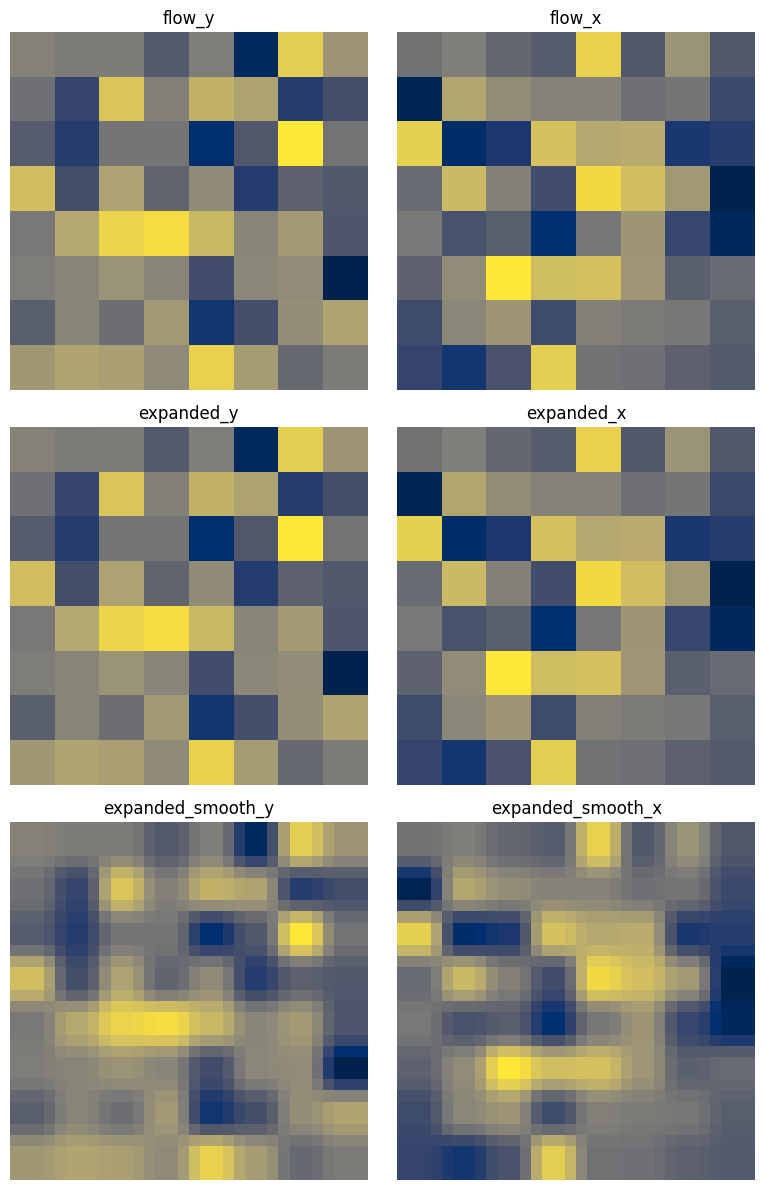

In [10]:
# def expand_2plus1(a: jax.Array) -> jax.Array:
#     doubled = a.repeat(2, axis=1).repeat(2, axis=2)
#     padded = jnp.pad(doubled,((0,0), (1,1), (1,1)), mode='edge')
#     return padded


def smooth_kernel3(a: jax.Array) -> jax.Array:
    """
    Smoothen entries on an array(img) by interpolating each entry with their neighbors with a
    specific kernel.
    The borders are copied over so that the kernel has enough context for smoothing.
    """
    extra_borders = jnp.pad(a, ((0, 0), (1, 1), (1, 1)), mode='edge')
    extra_borders_extra_dim = jnp.expand_dims(extra_borders, axis=1)
    gaussian_kernel = jnp.array([
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1]
    ], dtype=jnp.float32).reshape(1, 1, 3, 3)
    norm_kernel = gaussian_kernel / jnp.sum(gaussian_kernel)
    smoothed_extra_dim = jax.lax.conv(extra_borders_extra_dim, norm_kernel, (1, 1), 'valid')
    smoothed = smoothed_extra_dim.squeeze(axis=(1))
    return smoothed


def expand_flow_to_next_level_prior(level_flow: jax.Array, smooth: bool) -> jax.Array:
    upscaled_flow = 2 * level_flow
    expanded_upscaled_flow = upscaled_flow.repeat(2, axis=1).repeat(2, axis=2)
    # padded_expanded_upscaled_flow = jnp.pad(
    #     expanded_upscaled_flow, ((0, 0), (1, 1), (1, 1)))
    if smooth:
        expanded_upscaled_flow = smooth_kernel3(expanded_upscaled_flow)
    return expanded_upscaled_flow


a = jax.random.normal(jax.random.key(12), shape=(2, 8, 8)).astype(jnp.float32) * 0.3
expanded = expand_flow_to_next_level_prior(a, smooth=False)
expanded_smooth = expand_flow_to_next_level_prior(expanded, smooth=True)
display_arrays(cols=2, rows=3, flow_y=a[0], flow_x=a[1], expanded_y=expanded[0],
               expanded_x=expanded[1], expanded_smooth_y=expanded_smooth[0],
               expanded_smooth_x=expanded_smooth[1])
# doubled = expand_2plus1(a)
# smoothed = smooth_kernel3(doubled)
# display_arrays(cols=2, rows=2, doubled_y=doubled[0] ,doubled_x=doubled[1], smoothed_y=smoothed[0],
#                smoothed_x=smoothed[1])


(4, 2, 2) (2, 1, 1)
(4, 4, 4) (2, 2, 2)
(4, 8, 8) (2, 4, 4)
(4, 16, 16) (2, 8, 8)
(4, 32, 32) (2, 16, 16)
(4, 64, 64) (2, 32, 32)


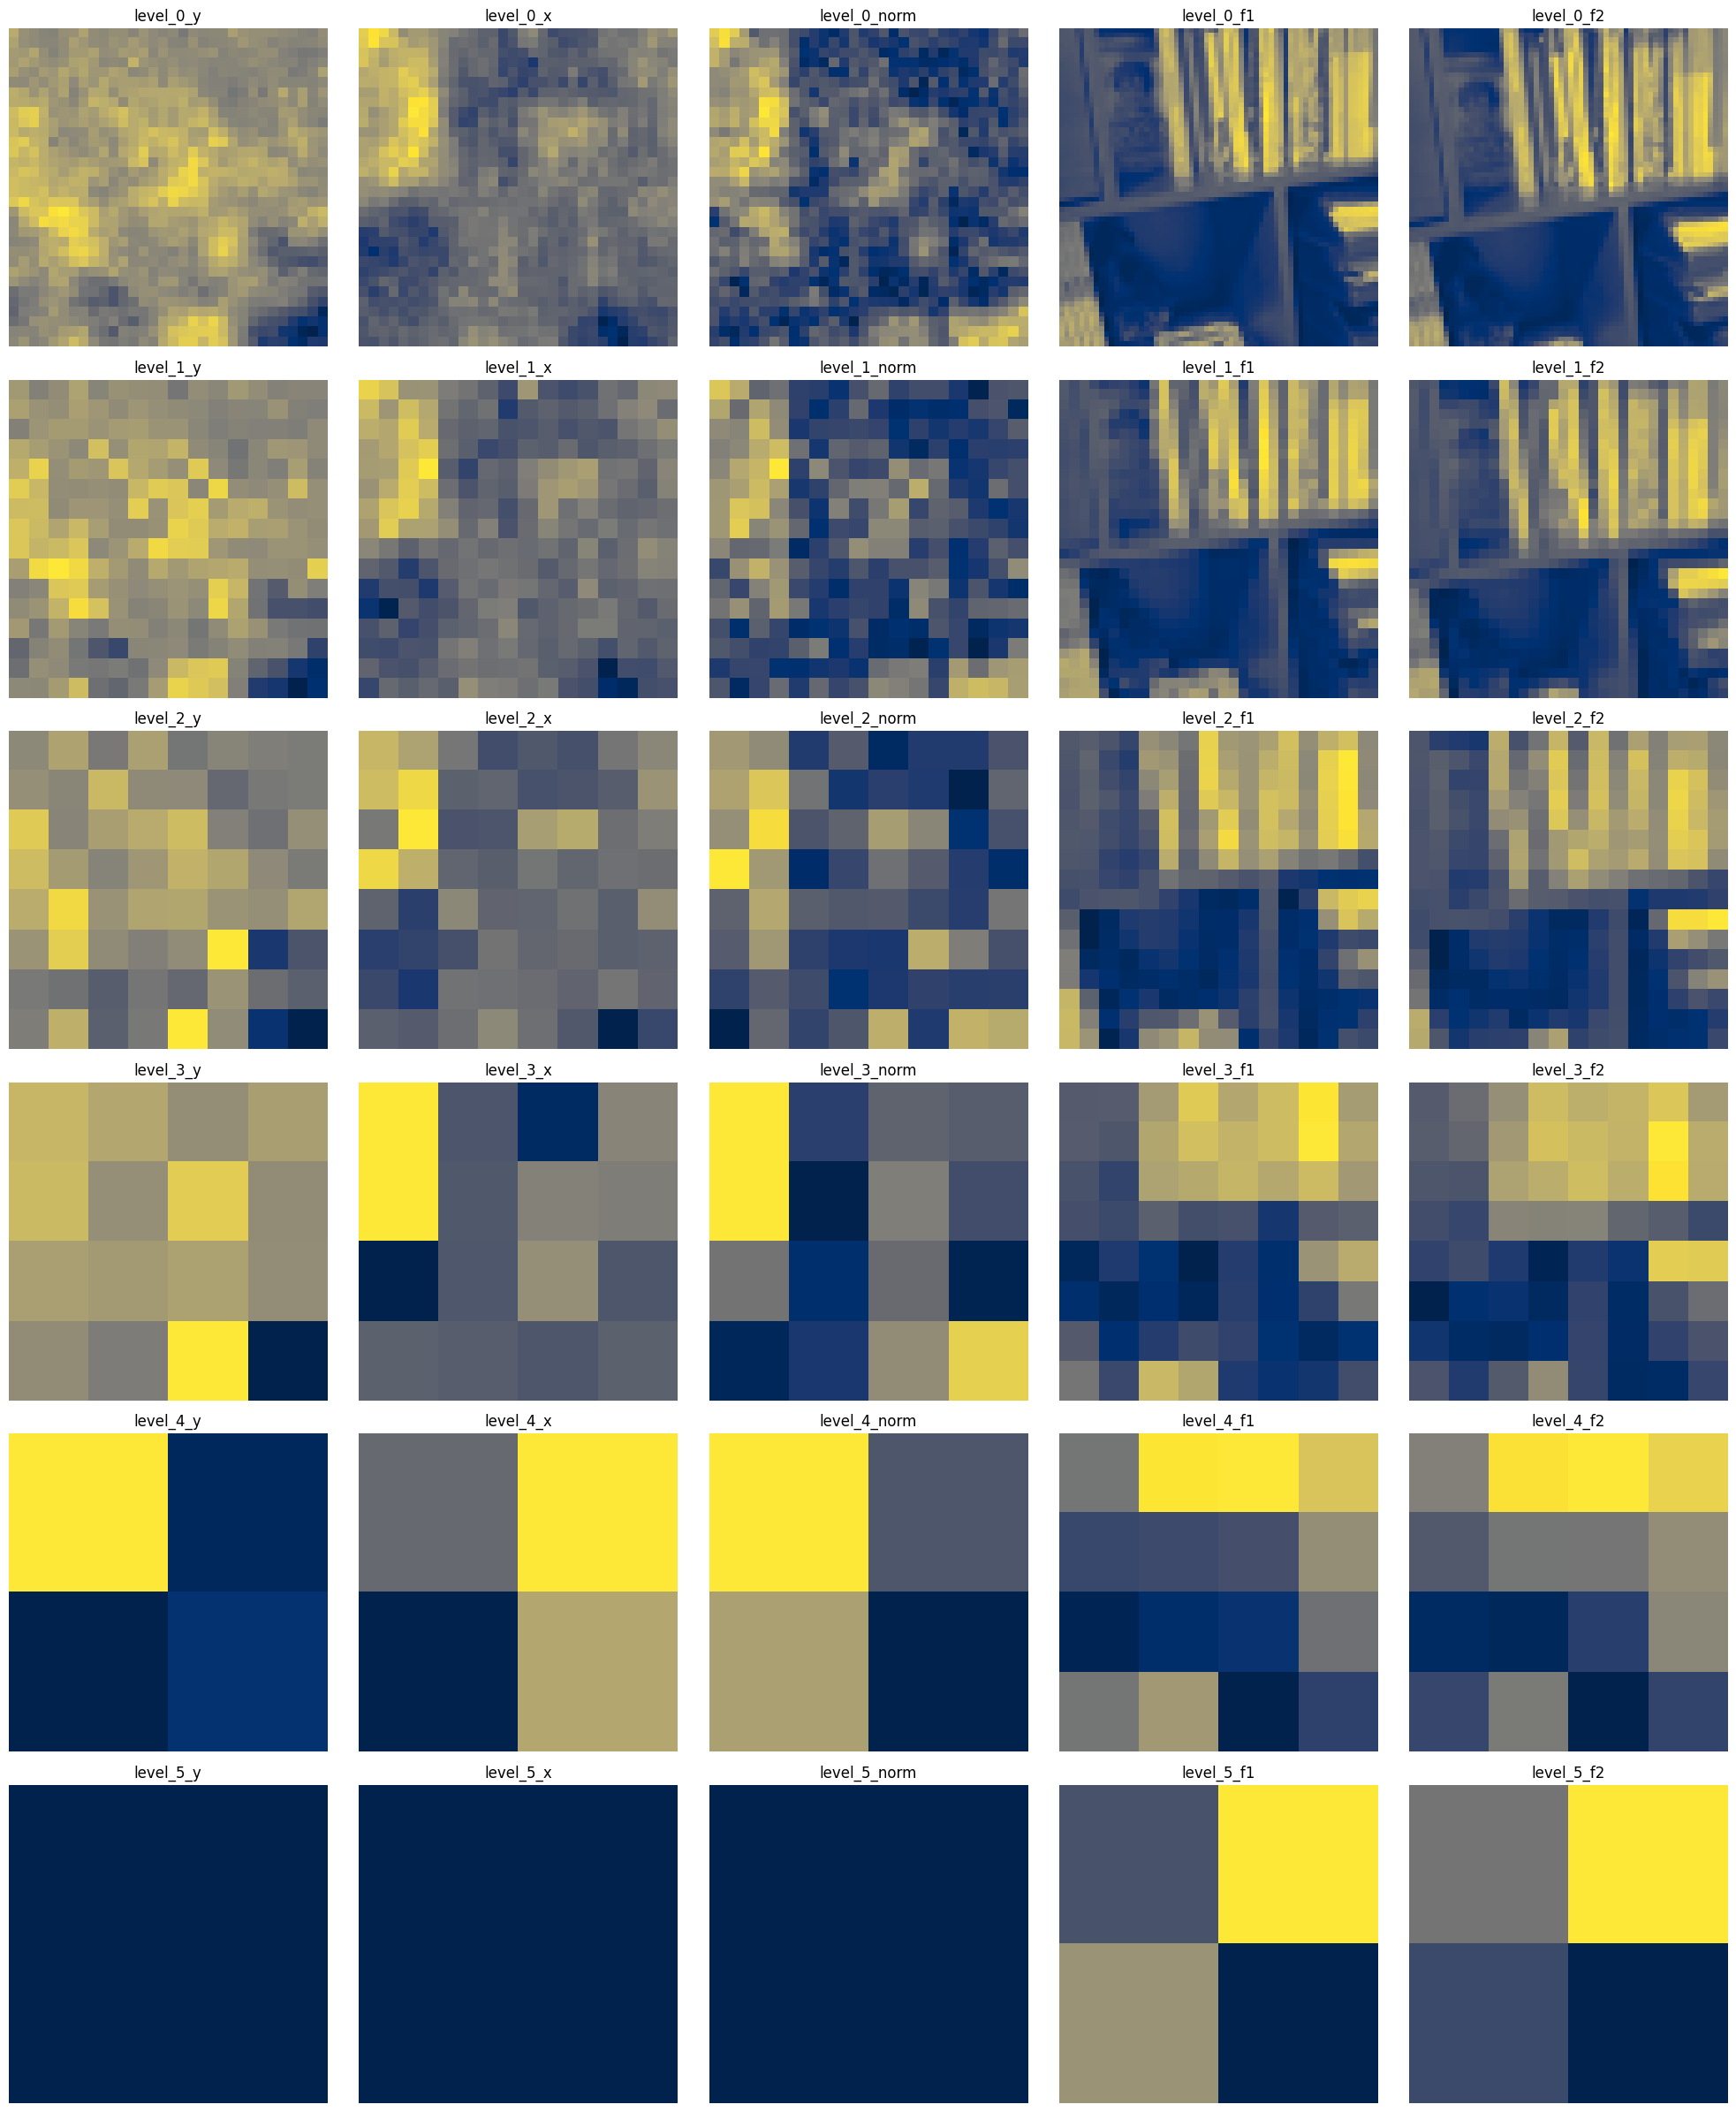

In [34]:
from functools import partial
from typing import Sequence


def multi_channel_patch_pair_similarity(patch1, patch2):
    per_channel = jax.vmap(patch_pair_similarity)(patch1, patch2)
    overall = jnp.mean(per_channel)
    return overall


def multi_channel_patch_flow_similarity(patch1, patch2, flow):
    warped_patch2 = (
        jax.vmap(get_warped_patch_without_context_window, in_axes=(0, None))
        (patch2, flow)
    )
    return multi_channel_patch_pair_similarity(patch1, warped_patch2)


def single_channel_patch_flow_similarity(patch1, patch2, flow):
    warped_patch2 = get_warped_patch_without_context_window(patch2[0], flow)
    return patch_pair_similarity(patch1[0], warped_patch2)


single_channel_patch_flow_similarity_grad = jax.grad(single_channel_patch_flow_similarity,
                                                     argnums=2)
multi_channel_patch_flow_similarity_grad = jax.grad(multi_channel_patch_flow_similarity, argnums=2)


def estimate_residual_flow(frame1_patch, frame2_patch, prior) -> jax.Array:
    # individual frame are [C,P,P], prior
    # remainder_prior is [2]
    C, P, PP = frame1_patch.shape
    assert P == PP
    assert frame1_patch.shape == frame2_patch.shape
    assert prior.shape == (2,)
    flow = prior
    for i in range(5):
        grad = multi_channel_patch_flow_similarity_grad(frame1_patch, frame2_patch, flow)
        flow += 0.1 * grad
    return flow - prior


# @partial(jax.jit, static_argnums=(3,))
def estimate_flow_for_layer(frame1: jax.Array, frame2: jax.Array, prior: jax.Array,
                            patch_size: int) -> jax.Array:
    """
    frame1 and frame2 have shapes: [C, H*P, W*P]
    prior has shape [2, H, W]
    """
    _, PH, PW = prior.shape
    print(frame1.shape, prior.shape)
    whole_priors = jnp.round(prior).astype(jnp.int32)
    remainder_priors = prior - whole_priors
    frame2_patches = extract_shifted_patches_multi_channel(frame2, whole_priors, patch_size)
    frame1_patches = extract_non_overlapping_patches(frame1, patch_size)
    flattened_patch_priors = remainder_priors.reshape(2, -1).transpose(1, 0)
    residual_flow = jax.vmap(estimate_residual_flow)(frame1_patches, frame2_patches,
                                                     flattened_patch_priors)

    residual_flow_patches = residual_flow.reshape(PH, PW, 2).transpose(2, 0, 1)
    net_flow = residual_flow_patches + prior
    return net_flow


def estimate_flow_through_layers(layers1: Sequence[jax.Array], layers2: Sequence[jax.Array],
                                 prior: jax.Array, patch_size: int) -> Sequence[jax.Array]:
    level_flows = []
    for f1, f2 in reversed(list(zip(layers1, layers2))):
        level_flow = estimate_flow_for_layer(f1, f2, prior, patch_size)
        level_flows.append(level_flow)
        prior = expand_flow_to_next_level_prior(level_flow, smooth=True)
    return level_flows[::-1]


jnp.set_printoptions(precision=4)
patch_size = 2
priors_h, priors_w = pyramid1[-1][0].shape
priors = (jax.random.normal(jax.random.key(25),
                            (2, priors_h // patch_size, priors_w // patch_size)) *
          0.01)
level_flows = estimate_flow_through_layers(pyramid1, pyramid2, priors, patch_size)
flow_norms = dict()
for i, level in enumerate(level_flows):
    flow_norm = jnp.linalg.norm(level, axis=0)
    flow_norms[f'level_{i}_y'] = level[0]
    flow_norms[f'level_{i}_x'] = level[1]
    flow_norms[f'level_{i}_norm'] = flow_norm
    flow_norms[f'level_{i}_f1'] = pyramid1[i][0]
    flow_norms[f'level_{i}_f2'] = pyramid2[i][0]

display_arrays(cols=5, rows=6, **flow_norms)
# print([level.shape for level in level_flows])

# f1 = pyramid1[-3][0]
# f2 = pyramid2[-3][0]
# prior = jnp.arange(0, 98).reshape(2, 7, 7) / 980.
# flow = estimate_flow_for_layer(f1, f2, prior, patch_size)
# # flow.shape
# flow_norm = jnp.linalg.norm(flow, axis=0)
# flow_norm
# # display_arrays(flow=flow_norm)
